In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv
import numpy as np
import scipy.special as special

In [2]:
cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
print(cs_factor)

4.643888037887359


In [3]:

factor = cs_factor
mv_test = 1
kvec = [1]
k_ind = 0
k = kvec[k_ind]
H0=67
Omega_M = 1
Omega_R = 0
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
# 
h = 0.6704
cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }


c = 3*1e5 # speed of lign in km/s
H0 /= (c) # i 1/Mpc
cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()

tid = bg['proper time [Gyr]'] * c / 306.4
# det kommer af Gyrs * c = 306.4 Mpc

pts = cosmo.get_perturbations()['scalar']

mv = mv_test * 1e-6

def cs(a,mv,factor):
    Tv_k = 1.947 # kelvin # MeV
    kb = 8.617e-11 # MeV/K
    T0 = Tv_k * kb
    mv = mv_test * 1e-6
    return factor *T0 / a / mv


# henter class data
#=======================
delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]
a_class = pts[k_ind]["a"]
#=======================

# interpolation af class data
# ==============================
tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
interp_tau_from_a = scipy.interpolate.interp1d(a_class,tau_class)
interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class)
delta_init = scipy.interpolate.interp1d(tau_class,delta_class)
delta_tid = scipy.interpolate.interp1d(tid_class,delta_class)
neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)
neu_interp = scipy.interpolate.interp1d(a_class,delta_neutrino_class)
a_interp = scipy.interpolate.interp1d(tau_class,a_class)
a_interp_tid = scipy.interpolate.interp1d(a_class,tid_class)
# ===============================


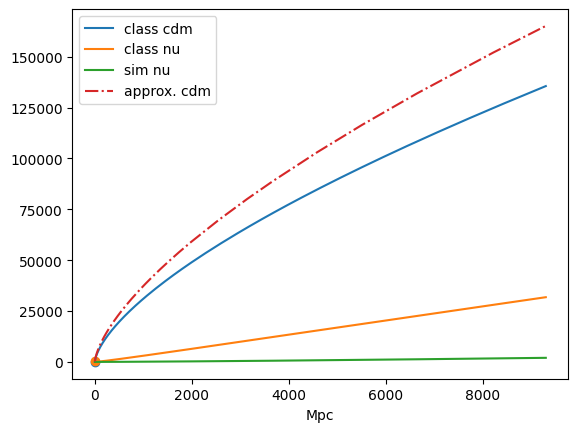

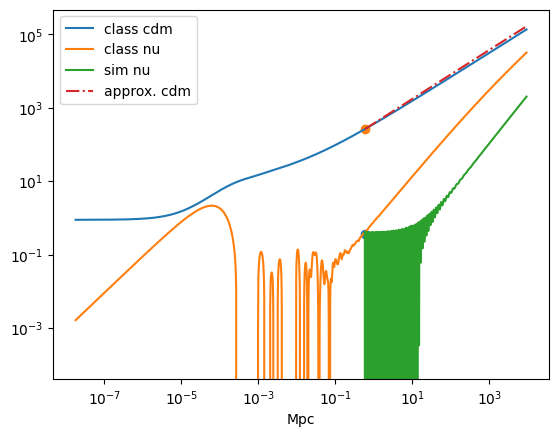

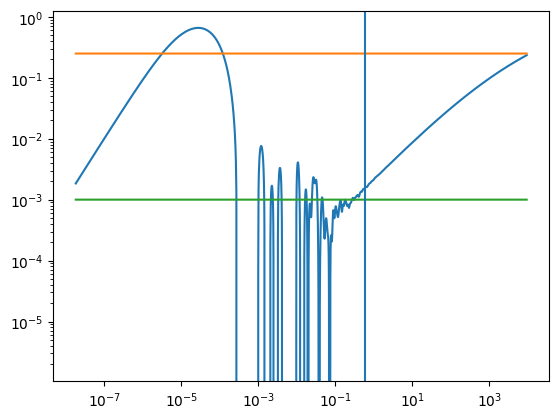

In [5]:
cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5  # det virker med denne skalering
cs_factor = 2.4
# valg a z-start værdi
# ===============================
z = 600
a0 = 1/(1+z)
a_span = [a0,1]
# ===============================
# danner start værdier for conformal og fysisk tid og delta_cdm
# ===============================
T_ini = float(interp_tau_from_a(a0))
T_ini_tid = float(interp_tid_from_a(a0))
T_0 =  float(T_ini_tid)
delta0 = delta_init(T_ini)
# ===============================


# JEg har skreve cs(a) som c/a i mathmatica så vi definere først c
# ===============================
c = cs(1,mv_test,factor)
# ===============================

# diff ligning i fysisk tid
# ===============================

def func(t,y,a0): 
    delta = y[0]
    t0 = tid[-1]
    d_delta = y[1]    
    H = 2/3 * t**(-1)
    a = (t/t0)**(2/3)
    
    d2_delta = - 2 * H * d_delta + 3/2 * (H**2) * delta0/(a0) * a - (c*k)**2 * delta/a**4 
    
    return [d_delta,d2_delta]

y0 = np.array([neu_interp(a0),0])
t = [T_0,tid[-1]]
t0 = t[-1]
a0 = ((T_0)/t0)**(2/3)
sol = scipy.integrate.solve_ivp(func,t,y0,args=(a0,))
# ===============================


plt.figure(1)
plt.plot(tid_class,-delta_class,label="class cdm")
plt.plot(tid_class,-delta_neutrino_class,label="class nu")
plt.plot(sol.t,-sol.y[0],label="sim nu")

# delta0/a0 * a 
D = delta0 / (sol.t[0]/sol.t[-1])**(2/3) * (sol.t/sol.t[-1])**(2/3)
plt.plot(sol.t,-D ,"-.",label="approx. cdm")

plt.xlabel("Mpc")
plt.scatter(T_ini_tid,-neu_interp(a0))
plt.scatter(T_ini_tid,-D[0])
plt.legend()

plt.figure(2)
plt.loglog(tid_class,-delta_class,label="class cdm")
plt.plot(tid_class,-delta_neutrino_class,label="class nu")

plt.plot(sol.t,-sol.y[0],label="sim nu")

plt.plot(sol.t,-D,"-.",label="approx. cdm")
plt.xlabel("Mpc")
plt.scatter(T_ini_tid,-neu_interp(a0))
plt.scatter(T_ini_tid,-D[0])
#plt.loglog(tid_class,-delta_class/4)
plt.legend()
plt.figure(12412)
plt.loglog(tid_class,delta_neutrino_class/delta_class)
plt.loglog(tid_class,[1/4 for i in tid_class])
plt.loglog(tid_class,[1e-3 for i in tid_class])
plt.axvline(T_0)

In [6]:
# C kode funktions kopier for at jeg nemt og hurtigt kan importere CForm af mathmatica løsningerne.
def Power(x,k):
    return np.power(x,k)
def Cos(x):
    return np.cos(x)

def Sin(x):
    return np.sin(x)

def CosIntegral(x):
    return special.sici(x)[1]

def SinIntegral(x):
    return special.sici(x)[0]

def Sqrt(x):
    return np.sqrt(x)

def Sinc(x):
    return np.sinc(x)


11.238943160853276 282.3760071326056
-0.9705316743365279 0.2409735859166645 -0.3591264096533678 0.9332889273368036
-2422623.6871143607 -26318579.289177746


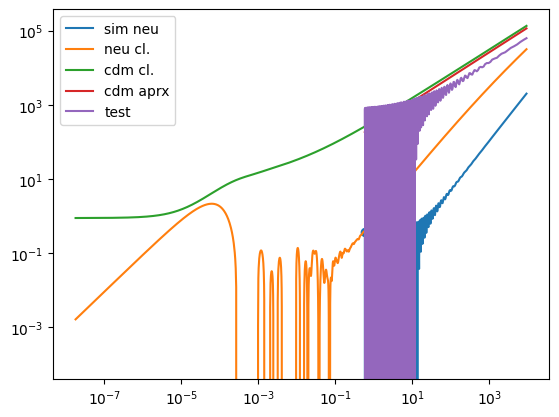

In [7]:

# diff ligning i fysisk tid
# ===============================
a0 = (float(T_0)/t0)**(2/3)

def func(t,y): # fysisk tid
    delta = y[0]
    t0 = tid[-1]
    d_delta = y[1]    
    H = 2/3 * t**(-1)
    a = (t/t0)**(2/3)
    a0 = (float(T_0)/t0)**(2/3)
    d2_delta = - 2 * 2/3 * t**(-1) * d_delta + 3/2 * ((2/3 * t**(-1))**2) * delta0/((float(T_ini_tid)/t0)**(2/3)) * (t/t0)**(2/3) - (c*k)**2 * delta/a**4 
        
    return [d_delta,d2_delta]

# startværdien for neutrinoer
d0 = neu_interp(a0)
t0 = tid_class[-1]
t = [T_0,t0]
y0 = [d0,-(0)]
# cs(a,mv,factor):
a0 = (T_0/t0) ** (2/3)

A = 3 * cs(1,mv_test,cs_factor) * k * t0
B = 3 * cs(a0,mv_test,cs_factor) * k * T_0/a0
print(A,B)
sA = np.sin(A)
cA = np.cos(A)
SIA, CIA = special.sici(A)
sB = np.sin(B)
cB = np.cos(B)
print(sA,cA,sB,cB)
SIB, CIB = special.sici(B)
dts = delta0
dvts = d0
dt0 = delta_class[-1]
dvt0 = delta_neutrino_class[-1]
C1 = (dts-dvts-dts*B**2 * CIB + sB * dts * B**2 * SIB - sB/sA *(dt0-dvt0 + cA * dt0 * A**2 * CIA + sA * dt0 * A**2 * SIA))/(sB*cA/sA - cB)
C2 = 1/ sA * (dt0 - dvt0 + cA * dt0 * A**2 * CIA + sA *dt0 * A**2 * SIA) + cA/sA * C1

print(C1,C2)

def f(t,k,t0):
    a = (t/t0)** (2/3)
    val = 3 * cs(a,mv_test,cs_factor) * k * t / a
    dcdm = delta0 / a0 *  a
    si,ci = special.sici(val)
    res = dcdm + np.cos(val) * (C1 + dcdm *(val)**2 * ci) - np.sin(val) * ( C2 - dcdm * val**2 * si)
    return res


def func5(t,t0,d0,delta0,c2k2,a0):
    a = np.power(t/t0,2/3)
    K1 = 1#delta0/ a0
    C1, C2 = 1,1#K1 * a,-K1*a
    return (-100/ a0*Power(t,2/3))/Power(t0,2/3) + 10*Cos((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3))* (C1 + 9*c2k2*K1*Power(t0,2)* CosIntegral((3*Sqrt(c2k2)*Power(t0,4/3))/ Power(t,1/3))) - Sin((3*Sqrt(c2k2)*Power(t0,4/3))/Power(t,1/3))* (C2 - 9*c2k2*K1*Power(t0,2)* SinIntegral((3*Sqrt(c2k2)*Power(t0,4/3))/ Power(t,1/3)))

sol = scipy.integrate.solve_ivp(func,t,y0)

plt.loglog(sol.t,-sol.y[0],label="sim neu")
plt.plot(tid_class,-delta_neutrino_class,label="neu cl.")
plt.plot(tid_class,-delta_class,label="cdm cl.")
plt.loglog(sol.t,-delta0 * (sol.t)**(2/3),label="cdm aprx")
plt.scatter(T_0,-d0)
t = sol.t
ts = t[0]
t0 = t[-1]
c2k2 = c**2*k**2
plt.loglog(t,-func5(t,t0,d0,delta0,c2k2,a0),label="test")
#plt.loglog(t,-f(t,k,t0))
plt.legend()


In [8]:
def func():
    return (K1*Power(t,0.6666666666666666))/Power(t0,0.6666666666666666) + Cos((3*Sqrt(c2k2)*Power(t0,1.3333333333333333))/Power(t,0.3333333333333333))* (C(1) + 9*c2k2*K1*Power(t0,2)* CosIntegral((3*Sqrt(c2k2)*Power(t0,1.3333333333333333))/ Power(t,0.3333333333333333))) - Sin((3*Sqrt(c2k2)*Power(t0,1.3333333333333333))/Power(t,0.3333333333333333))* (C(2) - 9*c2k2*K1*Power(t0,2)* SinIntegral((3*Sqrt(c2k2)*Power(t0,1.3333333333333333))/ Power(t,0.3333333333333333)))

Vi starter i $t_s$ og slutter i $t_0$ (idag)

$\ddot{\delta} +2 H \dot{\delta} + \frac{c_s ^2 k^2}{a^4}\delta = \frac{3}{2} H^2 \delta_{cdm}$

$\delta_{cdm} = \frac{\delta_{cdm,ts}}{a_s} a$

Hvor $a_s =  \left(\frac{t_s}{t_0}\right) ^{2/3}$

$a = \left(\frac{t}{t_0}\right) ^{2/3}$

$ H = \frac{2}{3} \frac{1}{t}$

i Mathmatica:

$ K1 = \delta_{cdm,ts} / a_s$

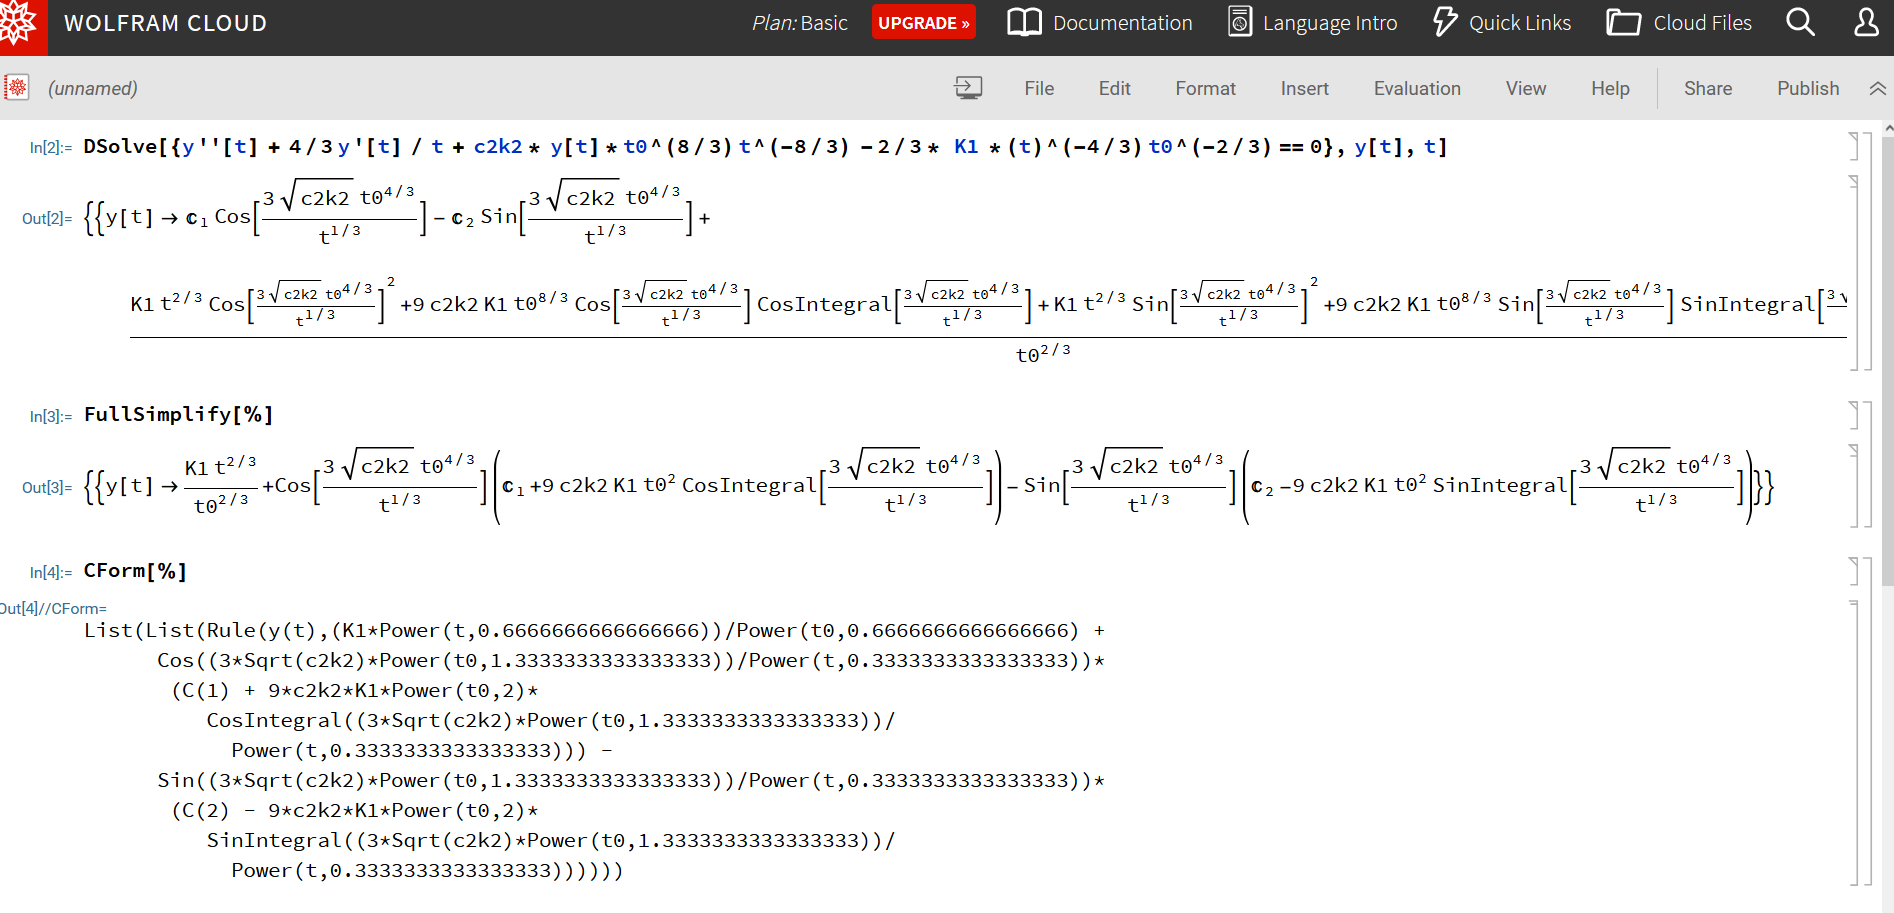

$A = 3 c_s(a=1) k t_0\; B = 3 c_s(a_{ts}) k t_s / a_{ts}$



$S_I A = sinIntegral(A)$

$C_I A = cosIntegral(A)$

$S_I B = sinIntegral(B)$

$C_I B = cosIntegral(B)$

$S_A = sin(A)\; C_A = cos(A) \; S_B = sin(B) \; C_B = cos(B)$

$c_1 = \frac{\delta_{ts}-\delta_{\nu,ts} + \delta(t_s)B^2 C_IB + s_B \delta_{ts} B^2 S_IB - \frac{s_B}{s_A}(\delta(t_0)-\delta_{\nu,t_0} + c_A \delta_{t_0} A^2 C_IA + s_A \delta_{t_0}A^2 S_I A)  }{S_BC_A/S_A - C_B}\;$
$c_2 = \frac{1}{s_A}(\delta_{t_0}-\delta_{\nu,t_0}+c_A \delta_{t_0} A^2 C_IA s_A \delta_{t_0} A^2 S_I A) + \frac{c_A}{s_A}c_1$


$\delta_{\nu} = \delta_{cdm} + \cos(3c_s(a) kt/a) \left(c_1 + \delta_{cdm} (3c_s(a)kt/a)^2cosInt(3c_s(a)kt/a)\right) - \sin(3c_s(a)kt/a)\left(c_2 - \delta_{cdm}(3c_s(a)kt/a)^2SinInt(3c_s(a)kt/a)\right)$
